# Ajout d'individus dans notre base de données

Comme la calibration s'applique à varier les poids des individus existants dans l'ERFS-FPR, il faut ajouter quasi manuellement les profils manquants (souvent les hauts revenus). Pour cela, on repère les déciles de POTE qui sont inexistants dans la base ERFS-FPR.

## Imports

In [ ]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import random
import unittest
from collections import Counter

import pandas as pd
from leximpact_common_python_libraries.config import Configuration

from leximpact_survey_scenario.scenario_tools.helpers_survey_scenario import (
    distrib_to_quantiles,
    get_quantiles_casd,
    individus_to_entity,
    pote_comparison,
)

config = Configuration(project_folder="leximpact-prepare-data")
tc = unittest.TestCase()

In [ ]:
# log.debug(config)
import numpy as np
from leximpact_common_python_libraries.logger import logger as log

from leximpact_prepare_data.helpers_survey_scenario import compare_distributions
from leximpact_prepare_data.leximpact_survey_scenario_tools import (
    LeximpactErfsSurveyScenario,
)

# from leximpact_socio_fisca_simu_etat.logger import logger as log

In [ ]:
!ls {config.get("ERFS")}

01_erfs_red_2018.h5
01_erfs_reduced_2018.h5
01_erfs_reduced_ind2018.h5
02_erfs_enlarged_2018.h5
02_erfs_enlarged_2018_dev.h5
02_erfs_enlarged_ind2018.h5
03_erfs_rfr_2018.h5
03_erfs_rfr_cal_ff2018.h5
03_erfs_rfr_cal_ind2018.h5
03_erfs_rfr_ind2018.h5
04_erfs_rfr_2018.h5
04_erfs_var_copules_2018.h5
04_erfs_var_copules_2018_dev.h5
05_erfs_ff2018_inflated_to_2018.h5
05_erfs_ff2018_inflated_to_2019.h5
05_erfs_ind2018_inflated_to_2018.h5
05_erfs_ind2018_inflated_to_2019.h5
06_erfs_ff_2018_aged_2021_dev.h5
07_erfs_copules_ff2018_inflated_to_2018.h5
07_erfs_copules_ff2018_inflated_to_2019.h5
07_erfs_copules_ind2018_inflated_to_2018.h5
07_erfs_copules_ind2018_inflated_to_2019.h5
07_erfs_salaire_to_cal_ind2018_inflated_to_2019.h5
08_erfs_salaire_cal_ind2018_inflated_to_2019.h5
base_2021
dummy_data_final.h5
erfs_final_ff_2018_aged_to_2021_N_3.h5
erfs_final_ind_2018_aged_to_2021_N_3.h5
erfs_flat_2018.h5
erfs_var_copules_2018_dev.h5
input-2022-09-19_branche_update_off.h5
pipeline_2022
sample_pop.csv

In [ ]:
# Import des années
annee_erfs = config.get("YEAR_ERFS")
annee_pote = config.get("YEAR_POTE")
annee_de_calcul = config.get("YEAR_COMPUTATION")

## Fonction d'ajout d'individus

### Old code

#### Ajout de foyers/individus dans la distribution

In [ ]:
"""
    Ajout de foyers (qui sont égaux à un unique individu) dans la distribution
"""


def ajout_gens(erfs_ind, var_name, Distrib_POTE, Distrib_ERFS):
    initial_length = len(erfs_ind)
    buckets = Distrib_ERFS.bucket_list
    list_missing = []
    # On parcourt les buckets
    for i in range(len(buckets)):
        idx = buckets[str(i)].nb
        # Si on a un bucket vide alors que le quantile n'est pas vide, et qu'on n'est pas dans le 1er bucket
        if (
            (buckets[str(i)].nb_ff == 0)
            and (Distrib_POTE.bucket_list[str(i)].nb != 0)
            and (idx != 0)
        ):
            list_missing.append(idx)

    print("List missing", list_missing)  # debug

    # Si besoin on crée des individus
    if len(list_missing) > 0:
        print("On a ", len(list_missing), "buckets vides")
        new_ff = create_ppl_HR(
            erfs_ind, var_name, list_missing, Distrib_POTE, Distrib_ERFS
        )
        tc.assertGreater(len(new_ff), 0)
        # On sauvegarde cela dans la nouvelle base
        erfs_ind_new = save_new_ff_to_ind(erfs_ind, new_ff)

        assert initial_length < len(erfs_ind_new)
    else:
        erfs_ind_new = erfs_ind.copy(deep=True)

    return erfs_ind_new

'\n    Ajout de foyers (qui sont égaux à un unique individu) dans la distribution\n'

#### Création de nouvelles personnes piochées dans un bucket

In [ ]:
"""
    Création de nouvelles personnes
    On notera qu'on ajoute uniquement des déclarants principaux, donc ici foyer=gens
"""


def create_ppl_HR(erfs_ind, var_name, list_missing, Distrib_POTE, Distrib_ERFS):
    # On pioche pour chaque bucket le nombre de personnes manquantes
    for id_x in list_missing:
        # 0 - Choix de l'échantillon où piocher
        erfs_ff = individus_to_entity(erfs_ind, "foyer_fiscal")
        echantillon_ou_piocher = get_similar_sample(
            id_x, erfs_ff, var_name, list_missing, Distrib_POTE, Distrib_ERFS
        )
        assert (
            echantillon_ou_piocher.empty is False
        ), "Attention, l'échantillon où piocher est vide"

        # 1 - Choix du nombre de foyers que l'on doit ajouter
        Nb_wanted = Distrib_POTE.bucket_list[str(id_x)].nb_ff
        seuil_inf = Distrib_POTE.bucket_list[str(id_x)].seuil_inf
        seuil_max = Distrib_POTE.bucket_list[str(id_x)].seuil_max
        # Si c'est trop, on en prend au max 0.5% de la population
        if Nb_wanted > 1000:
            Nb = int(round(len(erfs_ff) / 200, 0))
            # print("inf 1000", Nb)
        else:
            Nb = int(Nb_wanted)
            # print("Else", Nb)

        # 2 - Sélection au hasard de gens
        print(
            "On ajoute ",
            Nb,
            " personnes dans le bucket ",
            id_x,
            "entre ",
            seuil_inf,
            " et ",
            seuil_max,
        )
        # Si on peut, on essaye de ne pas prendre plusieurs fois le meme foyer
        if Nb >= len(echantillon_ou_piocher):
            new_ff = echantillon_ou_piocher.sample(n=Nb, replace=True).reset_index(
                drop=True
            )
        else:
            new_ff = echantillon_ou_piocher.sample(n=Nb, replace=False).reset_index(
                drop=True
            )
            # print("echantillon \n", echantillon_ou_piocher)
        # TODO : on fixe le random-state pour plus de stabilité?

        # 3 - On calibre
        sum_wanted = Distrib_POTE.bucket_list[str(id_x)].sum_
        new_ff_cal = calibrate_new_ff(
            new_ff, Nb_wanted, var_name, seuil_inf, seuil_max, sum_wanted
        )

        print("new_ff", len(new_ff_cal))  # debug

        #
        save_new_ff_to_ind

    return new_ff_cal

"\n    Création de nouvelles personnes\n    On notera qu'on ajoute uniquement des déclarants principaux, donc ici foyer=gens\n"

#### Obtention d'un échantillon où piocher des foyers à dupliquer

In [ ]:
def get_similar_sample(
    id_, erfs_ff, var_name, list_missing, Distrib_POTE, Distrib_ERFS
):
    """On décide de sélectionner des profils "proches",
    donc dans les 2 buckets non vides précédant le bucket vide,
    ou les 2 suivants s'il n'y en a pas
    """

    not_missing = list(
        (
            Counter(Distrib_POTE.df.index.values.astype(int)) - Counter(list_missing)
        ).elements()
    )
    # We do not account for the first bucket
    if not_missing[0] == 0:
        not_missing = not_missing[1:]

    # Getting last 2 not empty
    ids = []
    for i in reversed(not_missing):
        # Finding 2 buckets below
        if (i < id_) and (len(ids) < 2):
            ids.append(i)
    # If we couldn't find 2 buckets below
    if len(ids) < 2:
        for i in not_missing:
            if (i > id_) and (len(ids) < 2):
                ids.append(i)
    assert len(ids) == 2

    # Selected sample
    id_min = min(ids)
    id_max = max(ids)
    sample = erfs_ff.loc[
        (erfs_ff[var_name] >= Distrib_POTE.bucket_list[str(id_min)].seuil_inf)
        & (erfs_ff[var_name] < Distrib_POTE.bucket_list[str(id_max)].seuil_max)
    ].copy(deep=True)
    assert sample.empty is False, "Attention, l'échantillon où piocher est vide"

    return sample

#### Calibration des foyers nouvellement créés

In [ ]:
def calibrate_new_ff(new_ff, Nb_wanted, var_name, seuil_inf, seuil_max, sum_wanted):
    # Calibration des poids
    rate = Nb_wanted / (new_ff["wprm"].sum())
    new_ff.loc[:, "wprm"] = new_ff["wprm"].apply(lambda row: row * rate)
    tc.assertAlmostEqual(new_ff["wprm"].sum(), Nb_wanted)

    # Calibration de la variable d'intéret
    # 1 - On leur attribue une valeur comprise dans le bucket (+/- 5% pour avoir une marge)
    new_ff.loc[:, var_name] = [
        random.randint(
            round(seuil_inf, 0) + 10, round(seuil_max, 0) - 10
        )  # round(1.05*seuil_inf), round(0.95*seuil_max))
        for ppl in range(len(new_ff))
    ]
    sum_ponderee = (new_ff[var_name] * new_ff["wprm"]).sum()

    # 2 - On recalibre
    error = 1
    while error > 0.001:
        coef = sum_wanted / sum_ponderee
        # On update les valeurs
        new_ff.loc[:, var_name] = new_ff[var_name].apply(
            lambda row: max(min((row * coef), seuil_max - 1), seuil_inf + 1)
        )
        sum_ponderee = (new_ff[var_name] * new_ff["wprm"]).sum()
        error = (sum_ponderee - sum_wanted) / sum_wanted

    tc.assertAlmostEqual(error, 0, places=0)

    return new_ff

#### Injection des nouveaux foyers dans la base individus

In [ ]:
""" Mise en forme des foyers créés dans la base en individus """


def save_new_ff_to_ind(erfs_ind, new_ff):
    # On cherche les individus qui composent les nouveaux foyers fiscaux
    id_list = list(new_ff["foyer_fiscal_id"])
    new_people = erfs_ind[erfs_ind["foyer_fiscal_id"].isin(id_list)]

    # On leur attribue les nouveaux poids calibrés
    for id_foy in id_list:
        new_people[new_people["foyer_fiscal_id"] == id_foy]["wprm"] = new_ff[
            new_ff["foyer_fiscal_id"] == id_foy
        ]["wprm"]

    # new_people = new_people.copy().reset_index(drop=True)
    new_people = new_people.reset_index(drop=True)

    # Création des Idfoy, Idfam, Idmen uniques
    max_idfoy = (
        max(erfs_ind["foyer_fiscal_id"]) + 1
    )  # S'update à chaque ajout de bucket
    dict_ = {}
    i = 1
    new_people["new_foyer_fiscal_id"] = new_people["foyer_fiscal_id"]
    for id_foy in id_list:
        dict_[id_foy] = max_idfoy + i
        new_people[new_people["foyer_fiscal_id"] == id_foy]["famille_id"] = (
            max_idfoy + i
        )
        new_people[new_people["foyer_fiscal_id"] == id_foy]["menage_id"] = max_idfoy + i
        new_people[new_people["foyer_fiscal_id"] == id_foy]["new_foyer_fiscal_id"] = (
            max_idfoy + i
        )
        i += 1

    new_people["foyer_fiscal_id"] = new_people["new_foyer_fiscal_id"]
    new_people.drop("new_foyer_fiscal_id", axis=1)
    # TODO PROPAGER AUX POIDS des autres entites

    tc.assertEqual(new_people.isna().sum().sum(), 0)

    # On ajoute ces gens dans notre base en individus
    # new_ff.drop(['index'], axis=1)
    erfs_av = erfs_ind.copy()  # Pour le test
    erfs_ind = pd.concat([erfs_ind, new_people])
    erfs_ind = erfs_ind.reset_index(drop=True)
    tc.assertEqual(len(erfs_ind), len(erfs_av) + len(new_people))

    return erfs_ind

' Mise en forme des foyers créés dans la base en individus '

### New code

#### Ajout d'individus dans les quantiles vides

In [ ]:
def add_missing_indiv(scenario, annee_ajout, variable):
    # On va chercher le fichier de quantiles
    quantiles = get_quantiles_casd(variable)

    # On va chercher la base individus
    var_list = scenario._leximpact_variables
    base_indiv = scenario.create_data_frame_by_entity(
        variables=var_list, period=annee_ajout, merge=True
    )

    # On découpe la base en buckets de notre variable d'intérêt
    Distrib_BASE, Distrib_POTE, quantiles = distrib_to_quantiles(
        individus_to_entity(base_indiv, "foyer_fiscal"), variable, quantiles
    )

    # On identifie les buckets vides, on fabrique des individus et on les mets dans la base individus
    new_base_ind = ajout_gens(base_indiv, variable, Distrib_POTE, Distrib_BASE)
    new_base_ff = individus_to_entity(new_base_ind, "foyer_fiscal")

    # Plot des histogrammes de la new base
    fig, error_df, final_error = pote_comparison(
        individus_to_entity(base_indiv, "foyer_fiscal"),
        variable,
        title_suffix="",
        log=True,
        base_ff_cal=new_base_ff,
    )
    print("Avant", len(base_indiv), "apres", len(new_base_ind))

    # On remplace la base par la nouvelle base dans notre scenario
    print(
        "ATTENTION TRAVAIL EN COURS \n Il faudra encore inserer cette base dans un scenario"
    )

    return new_base_ind, Distrib_BASE

In [ ]:
# Creation d'une base de test
variable = "rfr"
annee_ajout = 2019
leximpact_scenario = LeximpactErfsSurveyScenario(final_year=2022)
for year in range(int(annee_erfs), int(annee_de_calcul) + 1):
    rfr = np.array(leximpact_scenario.calculate_variable("rfr", period=year))
    leximpact_scenario.simulation.set_input("rfr", year, rfr)
    # print("max ap", max(rfr))

# Avant
base_indiv = leximpact_scenario.create_data_frame_by_entity(
    variables=leximpact_scenario._leximpact_variables, period=annee_ajout, merge=True
)
base_ff = individus_to_entity(base_indiv, "foyer_fiscal")

Distrib_BASE, Distrib_POTE, quantiles = distrib_to_quantiles(
    base_ff, variable, get_quantiles_casd(variable)
)


# fig, error_df, final_error = pote_comparison(
#    base_ff, variable, title_suffix="", log=True
# )

Données du scénario : 
 {'input_data_table_by_entity_by_period': {2018: {'individu': 'individu_2018', 'menage': 'menage_2018'}, 2019: {'individu': 'individu_2018', 'menage': 'menage_2018'}, 2020: {'individu': 'individu_2018', 'menage': 'menage_2018'}, 2021: {'individu': 'individu_2018', 'menage': 'menage_2018'}, 2022: {'individu': 'individu_2018', 'menage': 'menage_2018'}}, 'survey': 'input'}


/home/jupyter-sasha/.cache/pypoetry/virtualenvs/leximpact-prepare-data-77FW3yLw-py3.8/lib/python3.8/site-packages/openfisca_core/holders/holder.py:167: Warning: You cannot set a value for the variable loyer, as it has been neutralized. The value you provided ([0. 0. 0. ... 0. 0. 0.]) will be ignored.
  return warnings.warn(
/home/jupyter-sasha/.cache/pypoetry/virtualenvs/leximpact-prepare-data-77FW3yLw-py3.8/lib/python3.8/site-packages/openfisca_core/holders/holder.py:167: Warning: You cannot set a value for the variable loyer, as it has been neutralized. The value you provided ([0. 0. 0. ... 0. 0. 0.]) will be ignored.
  return warnings.warn(
/home/jupyter-sasha/.cache/pypoetry/virtualenvs/leximpact-prepare-data-77FW3yLw-py3.8/lib/python3.8/site-packages/openfisca_core/holders/holder.py:167: Warning: You cannot set a value for the variable loyer, as it has been neutralized. The value you provided ([0. 0. 0. ... 0. 0. 0.]) will be ignored.
  return warnings.warn(
/home/jupyter-sasha/.c

On a une base initiale de  112144  individus pour  56935 foyer_fiscal s
On regroupe la base selon  ['weight_individus', 'weight_familles', 'weight_foyers', 'foyer_fiscal_id']
On a  56935 foyer_fiscal apres le groupby


/home/jupyter-sasha/leximpact-prepare-data/leximpact_prepare_data/helpers_survey_scenario.py:158: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sample_entity = sample_individus.groupby(wprm_list, as_index=False).sum()


Nombre de foyers de  rfr à zéro, dans l'ERFS :  3572896.0 et dans POTE :  2789455 soit un écart de :  28.08580887664436 %
[0, 0.5, 326.0, 1145.0, 2058.0, 3000.0, 3801.0, 4591.0, 5307.0, 5691.0, 6294.0, 6865.0, 7383.0, 7879.0, 8364.0, 8829.0, 9278.0, 9703.0, 10103.0, 10496.0, 10881.0, 11230.0, 11589.0, 11919.0, 12263.0, 12609.0, 12959.0, 13388.0, 13774.0, 14140.0, 14422.0, 14700.0, 14967.0, 15234.0, 15499.0, 15781.0, 16062.0, 16347.0, 16634.0, 16920.0, 17209.0, 17504.0, 17804.0, 18103.0, 18409.0, 18726.0, 19048.0, 19374.0, 19701.0, 20041.0, 20393.0, 20757.0, 21132.0, 21514.0, 21909.0, 22323.0, 22794.0, 23280.0, 23874.0, 24580.0, 25122.0, 25628.0, 26155.0, 26696.0, 27250.0, 27819.0, 28406.0, 29012.0, 29635.0, 30283.0, 30954.0, 31648.0, 32366.0, 33105.0, 33872.0, 34669.0, 35505.0, 36337.0, 37258.0, 38222.0, 39230.0, 40298.0, 41430.0, 42618.0, 43892.0, 45255.0, 46727.0, 48312.0, 50031.0, 51916.0, 54000.0, 56320.0, 58942.0, 61967.0, 65530.0, 69841.0, 75272.0, 82475.0, 92857.0, 110143.0, 148

On a une base initiale de  112144  individus pour  56935 foyer_fiscal s
On regroupe la base selon  ['weight_individus', 'weight_familles', 'weight_foyers', 'foyer_fiscal_id']
On a  56935 foyer_fiscal apres le groupby
Nombre de foyers de  rfr à zéro, dans l'ERFS :  3572896.0 et dans POTE :  2789455 soit un écart de :  28.08580887664436 %
[0, 0.5, 326.0, 1145.0, 2058.0, 3000.0, 3801.0, 4591.0, 5307.0, 5691.0, 6294.0, 6865.0, 7383.0, 7879.0, 8364.0, 8829.0, 9278.0, 9703.0, 10103.0, 10496.0, 10881.0, 11230.0, 11589.0, 11919.0, 12263.0, 12609.0, 12959.0, 13388.0, 13774.0, 14140.0, 14422.0, 14700.0, 14967.0, 15234.0, 15499.0, 15781.0, 16062.0, 16347.0, 16634.0, 16920.0, 17209.0, 17504.0, 17804.0, 18103.0, 18409.0, 18726.0, 19048.0, 19374.0, 19701.0, 20041.0, 20393.0, 20757.0, 21132.0, 21514.0, 21909.0, 22323.0, 22794.0, 23280.0, 23874.0, 24580.0, 25122.0, 25628.0, 26155.0, 26696.0, 27250.0, 27819.0, 28406.0, 29012.0, 29635.0, 30283.0, 30954.0, 31648.0, 32366.0, 33105.0, 33872.0, 34669.0, 355

/home/jupyter-sasha/leximpact-prepare-data/leximpact_prepare_data/helpers_survey_scenario.py:158: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sample_entity = sample_individus.groupby(wprm_list, as_index=False).sum()


List missing [103, 104]
On a  2 buckets vides
On a une base initiale de  112144  individus pour  56935 foyer_fiscal s
On regroupe la base selon  ['weight_individus', 'weight_familles', 'weight_foyers', 'foyer_fiscal_id']
On a  56935 foyer_fiscal apres le groupby
On ajoute  333  personnes dans le bucket  103 entre  8131520.0  et  29636994.0
new_ff 333
On a une base initiale de  112144  individus pour  56935 foyer_fiscal s
On regroupe la base selon  ['weight_individus', 'weight_familles', 'weight_foyers', 'foyer_fiscal_id']
On a  56935 foyer_fiscal apres le groupby
On ajoute  37  personnes dans le bucket  104 entre  29636994.0  et  1000000001
new_ff 37


/home/jupyter-sasha/leximpact-prepare-data/leximpact_prepare_data/helpers_survey_scenario.py:158: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sample_entity = sample_individus.groupby(wprm_list, as_index=False).sum()
/home/jupyter-sasha/leximpact-prepare-data/leximpact_prepare_data/helpers_survey_scenario.py:158: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sample_entity = sample_individus.groupby(wprm_list, as_index=False).sum()
/tmp/ipykernel_37717/2208608261.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

On a une base initiale de  112305  individus pour  56935 foyer_fiscal s
On regroupe la base selon  ['weight_individus', 'weight_familles', 'weight_foyers', 'foyer_fiscal_id']
On a  56935 foyer_fiscal apres le groupby
On a une base initiale de  112144  individus pour  56935 foyer_fiscal s
On regroupe la base selon  ['weight_individus', 'weight_familles', 'weight_foyers', 'foyer_fiscal_id']
On a  56935 foyer_fiscal apres le groupby


/home/jupyter-sasha/leximpact-prepare-data/leximpact_prepare_data/helpers_survey_scenario.py:158: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sample_entity = sample_individus.groupby(wprm_list, as_index=False).sum()
/home/jupyter-sasha/leximpact-prepare-data/leximpact_prepare_data/helpers_survey_scenario.py:158: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sample_entity = sample_individus.groupby(wprm_list, as_index=False).sum()


Index(['weight_individus', 'weight_familles', 'weight_foyers',
       'foyer_fiscal_id', 'quifam', 'retraite_brute',
       'cotisation_sociale_mode_recouvrement', 'ric',
       'traitement_indiciaire_brut', 'quifoy', 'activite', 'quimen',
       'heures_remunerees_volume', 'rag', 'retraite_imposable',
       'primes_fonction_publique', 'rnc', 'salaire_de_base',
       'autonomie_financiere', 'pensions_alimentaires_percues', 'idfam',
       'idfoy', 'idmen', 'chomage_imposable', 'chomage_brut',
       'effectif_entreprise', 'famille_id', 'menage_id', 'menage_role',
       'menage_position', 'rfr', 'f4ba', 'statut_occupation_logement',
       'weight_menages', 'wprm'],
      dtype='object')
Nombre de foyers de  rfr à zéro, dans l'ERFS :  3572896.0 et dans POTE :  2789455 soit un écart de :  28.08580887664436 %
[0, 0.5, 326.0, 1145.0, 2058.0, 3000.0, 3801.0, 4591.0, 5307.0, 5691.0, 6294.0, 6865.0, 7383.0, 7879.0, 8364.0, 8829.0, 9278.0, 9703.0, 10103.0, 10496.0, 10881.0, 11230.0, 11589.0

/home/jupyter-sasha/leximpact-prepare-data/leximpact_prepare_data/helpers_survey_scenario.py:158: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sample_entity = sample_individus.groupby(wprm_list, as_index=False).sum()


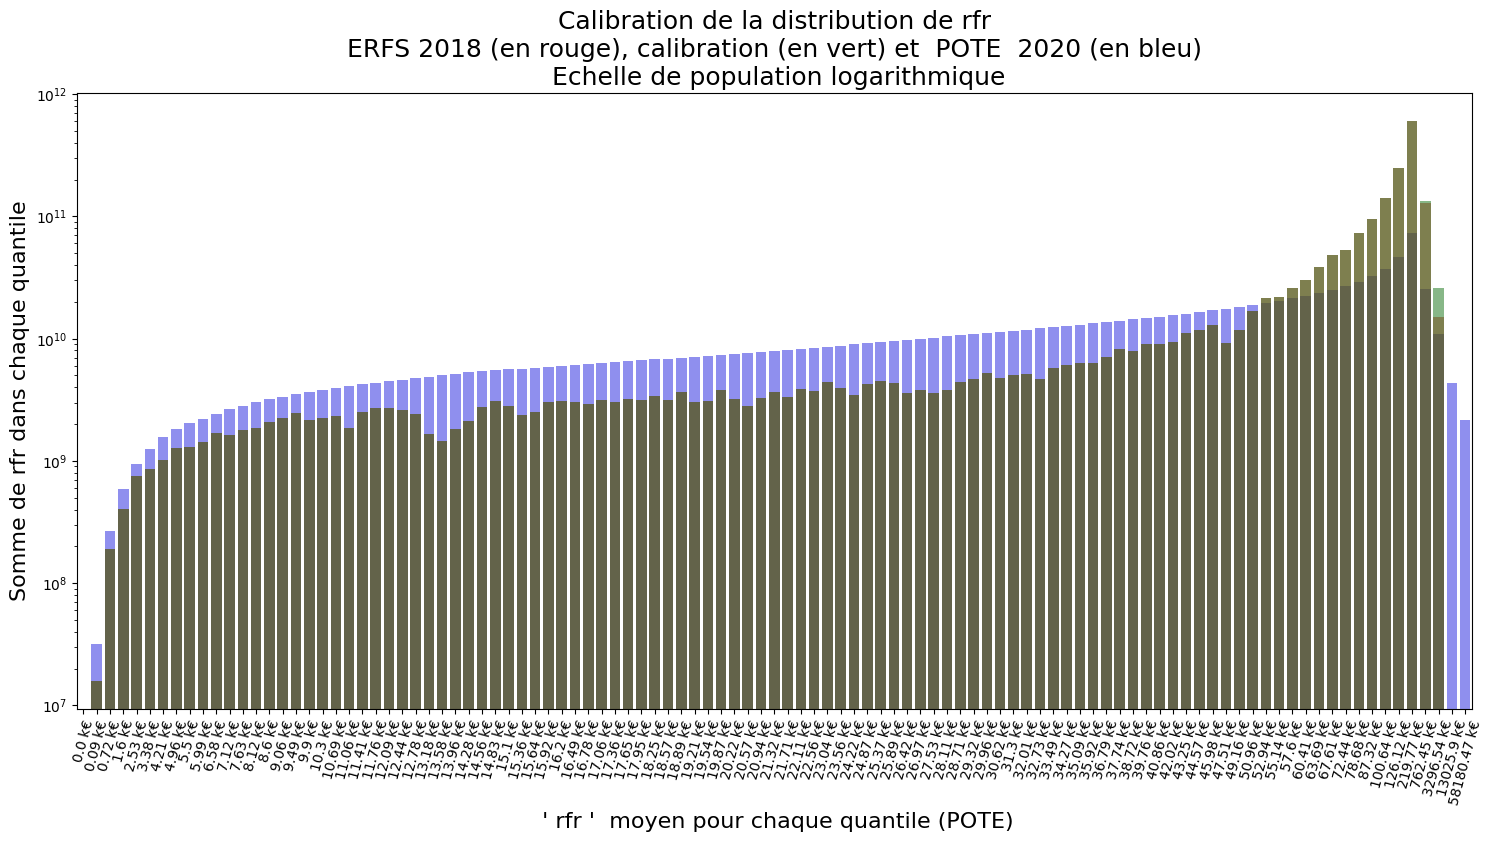

In [ ]:
# Ajout de gens
new_base, Distrib_BASE = add_missing_indiv(leximpact_scenario, annee_ajout, variable)
new_base_ff = individus_to_entity(new_base, "foyer_fiscal")

In [ ]:
1 / 0

ZeroDivisionError: division by zero

Données du scénario : 
 {'input_data_table_by_entity_by_period': {2018: {'individu': 'individu_2018', 'menage': 'menage_2018'}, 2019: {'individu': 'individu_2018', 'menage': 'menage_2018'}, 2020: {'individu': 'individu_2018', 'menage': 'menage_2018'}, 2021: {'individu': 'individu_2018', 'menage': 'menage_2018'}, 2022: {'individu': 'individu_2018', 'menage': 'menage_2018'}}, 'survey': 'input'}


/home/jupyter-sasha/.cache/pypoetry/virtualenvs/leximpact-prepare-data-77FW3yLw-py3.8/lib/python3.8/site-packages/openfisca_core/holders/holder.py:167: Warning: You cannot set a value for the variable loyer, as it has been neutralized. The value you provided ([0. 0. 0. ... 0. 0. 0.]) will be ignored.
  return warnings.warn(
/home/jupyter-sasha/.cache/pypoetry/virtualenvs/leximpact-prepare-data-77FW3yLw-py3.8/lib/python3.8/site-packages/openfisca_core/holders/holder.py:167: Warning: You cannot set a value for the variable loyer, as it has been neutralized. The value you provided ([0. 0. 0. ... 0. 0. 0.]) will be ignored.
  return warnings.warn(
/home/jupyter-sasha/.cache/pypoetry/virtualenvs/leximpact-prepare-data-77FW3yLw-py3.8/lib/python3.8/site-packages/openfisca_core/holders/holder.py:167: Warning: You cannot set a value for the variable loyer, as it has been neutralized. The value you provided ([0. 0. 0. ... 0. 0. 0.]) will be ignored.
  return warnings.warn(
/home/jupyter-sasha/.c

On a une base initiale de  112144  individus pour  56935 foyer_fiscal s
On regroupe la base selon  ['weight_individus', 'weight_familles', 'weight_foyers', 'foyer_fiscal_id']
On a  56935 foyer_fiscal apres le groupby


/home/jupyter-sasha/leximpact-prepare-data/leximpact_prepare_data/helpers_survey_scenario.py:158: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sample_entity = sample_individus.groupby(wprm_list, as_index=False).sum()


Nombre de foyers de  rfr à zéro, dans l'ERFS :  3572896.0 et dans POTE :  2789455 soit un écart de :  28.08580887664436 %
[0, 0.5, 326.0, 1145.0, 2058.0, 3000.0, 3801.0, 4591.0, 5307.0, 5691.0, 6294.0, 6865.0, 7383.0, 7879.0, 8364.0, 8829.0, 9278.0, 9703.0, 10103.0, 10496.0, 10881.0, 11230.0, 11589.0, 11919.0, 12263.0, 12609.0, 12959.0, 13388.0, 13774.0, 14140.0, 14422.0, 14700.0, 14967.0, 15234.0, 15499.0, 15781.0, 16062.0, 16347.0, 16634.0, 16920.0, 17209.0, 17504.0, 17804.0, 18103.0, 18409.0, 18726.0, 19048.0, 19374.0, 19701.0, 20041.0, 20393.0, 20757.0, 21132.0, 21514.0, 21909.0, 22323.0, 22794.0, 23280.0, 23874.0, 24580.0, 25122.0, 25628.0, 26155.0, 26696.0, 27250.0, 27819.0, 28406.0, 29012.0, 29635.0, 30283.0, 30954.0, 31648.0, 32366.0, 33105.0, 33872.0, 34669.0, 35505.0, 36337.0, 37258.0, 38222.0, 39230.0, 40298.0, 41430.0, 42618.0, 43892.0, 45255.0, 46727.0, 48312.0, 50031.0, 51916.0, 54000.0, 56320.0, 58942.0, 61967.0, 65530.0, 69841.0, 75272.0, 82475.0, 92857.0, 110143.0, 148

/home/jupyter-sasha/leximpact-prepare-data/leximpact_prepare_data/helpers_survey_scenario.py:158: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sample_entity = sample_individus.groupby(wprm_list, as_index=False).sum()


List missing [103, 104]
On a  2 buckets vides
On a une base initiale de  112144  individus pour  56935 foyer_fiscal s
On regroupe la base selon  ['weight_individus', 'weight_familles', 'weight_foyers', 'foyer_fiscal_id']
On a  56935 foyer_fiscal apres le groupby
On ajoute  333  personnes dans le bucket  103 entre  8131520.0  et  29636994.0
new_ff 333
On a une base initiale de  112144  individus pour  56935 foyer_fiscal s
On regroupe la base selon  ['weight_individus', 'weight_familles', 'weight_foyers', 'foyer_fiscal_id']
On a  56935 foyer_fiscal apres le groupby
On ajoute  37  personnes dans le bucket  104 entre  29636994.0  et  1000000001
new_ff 37


/home/jupyter-sasha/leximpact-prepare-data/leximpact_prepare_data/helpers_survey_scenario.py:158: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sample_entity = sample_individus.groupby(wprm_list, as_index=False).sum()
/home/jupyter-sasha/leximpact-prepare-data/leximpact_prepare_data/helpers_survey_scenario.py:158: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sample_entity = sample_individus.groupby(wprm_list, as_index=False).sum()
/tmp/ipykernel_37717/2208608261.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

On a une base initiale de  112294  individus pour  56935 foyer_fiscal s
On regroupe la base selon  ['weight_individus', 'weight_familles', 'weight_foyers', 'foyer_fiscal_id']
On a  56935 foyer_fiscal apres le groupby
On a une base initiale de  112144  individus pour  56935 foyer_fiscal s
On regroupe la base selon  ['weight_individus', 'weight_familles', 'weight_foyers', 'foyer_fiscal_id']
On a  56935 foyer_fiscal apres le groupby


/home/jupyter-sasha/leximpact-prepare-data/leximpact_prepare_data/helpers_survey_scenario.py:158: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sample_entity = sample_individus.groupby(wprm_list, as_index=False).sum()


Index(['weight_individus', 'weight_familles', 'weight_foyers',
       'foyer_fiscal_id', 'quifam', 'retraite_brute',
       'cotisation_sociale_mode_recouvrement', 'ric',
       'traitement_indiciaire_brut', 'quifoy', 'activite', 'quimen',
       'heures_remunerees_volume', 'rag', 'retraite_imposable',
       'primes_fonction_publique', 'rnc', 'salaire_de_base',
       'autonomie_financiere', 'pensions_alimentaires_percues', 'idfam',
       'idfoy', 'idmen', 'chomage_imposable', 'chomage_brut',
       'effectif_entreprise', 'famille_id', 'menage_id', 'menage_role',
       'menage_position', 'rfr', 'f4ba', 'statut_occupation_logement',
       'weight_menages', 'wprm'],
      dtype='object')
Nombre de foyers de  rfr à zéro, dans l'ERFS :  3572896.0 et dans POTE :  2789455 soit un écart de :  28.08580887664436 %
[0, 0.5, 326.0, 1145.0, 2058.0, 3000.0, 3801.0, 4591.0, 5307.0, 5691.0, 6294.0, 6865.0, 7383.0, 7879.0, 8364.0, 8829.0, 9278.0, 9703.0, 10103.0, 10496.0, 10881.0, 11230.0, 11589.0

AttributeError: 'DataFrame' object has no attribute 'df'

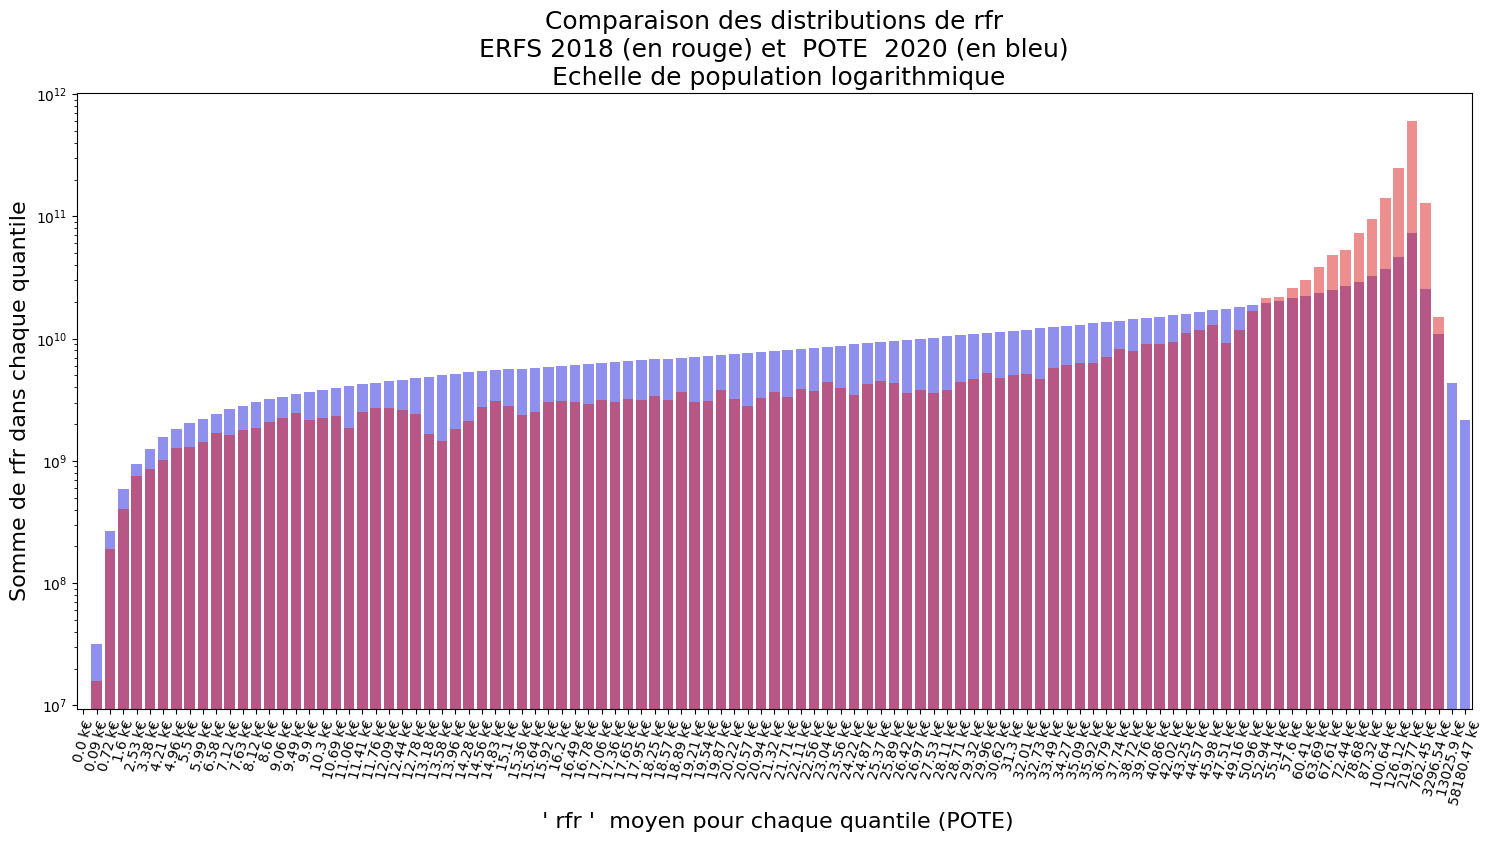

In [ ]:
def test_add_missing_indiv_rfr():
    # Creation d'une base de test
    variable = "rfr"
    annee_ajout = 2019
    leximpact_scenario = LeximpactErfsSurveyScenario(final_year=2022)
    for year in range(int(annee_erfs), int(annee_de_calcul) + 1):
        rfr = np.array(leximpact_scenario.calculate_variable("rfr", period=year))
        leximpact_scenario.simulation.set_input("rfr", year, rfr)
        # print("max ap", max(rfr))

    # Avant
    base_indiv = leximpact_scenario.create_data_frame_by_entity(
        variables=leximpact_scenario._leximpact_variables,
        period=annee_ajout,
        merge=True,
    )
    base_ff = individus_to_entity(base_indiv, "foyer_fiscal")

    Distrib_BASE, Distrib_POTE, quantiles = distrib_to_quantiles(
        base_ff, variable, get_quantiles_casd(variable)
    )

    fig, error_df, final_error = pote_comparison(
        base_ff, variable, title_suffix="", log=True
    )

    # Ajout de gens
    Distrib_BASE3, Distrib_POTE3 = add_missing_indiv(
        leximpact_scenario, annee_ajout, variable
    )

    fig, error_df, final_error = pote_comparison(
        Distrib_BASE.df,
        variable,
        title_suffix="",
        log=True,
        base_ff_cal=Distrib_BASE3.df,
    )

    # Validation
    # assert pas de bucket vide
    tc.assertEqual((Distrib_BASE3.df["nb_ff"] == 0).unique() is False, True)
    # assert sum de var X dans le bucket ~ celle du bucket de POTE
    tc.assertEqual(Distrib_BASE.df["sum"], Distrib_POTE3.df["sum"])
    # assert moyenne des autres var n'a pas changé

    print("en cours")


test_add_missing_indiv_rfr()

### Exemple Minimum

#### Initialisation

In [ ]:
leximpact_scenario = LeximpactErfsSurveyScenario(final_year=2022)
for year in range(int(annee_erfs), int(annee_de_calcul) + 1):
    rfr = leximpact_scenario.calculate_variable("rfr", period=year)
    # leximpact_scenario.simulation.set_input("rfr", year, rfr)

Données du scénario : 
 {'input_data_table_by_entity_by_period': {2018: {'individu': 'individu_2018', 'menage': 'menage_2018'}, 2019: {'individu': 'individu_2018', 'menage': 'menage_2018'}, 2020: {'individu': 'individu_2018', 'menage': 'menage_2018'}, 2021: {'individu': 'individu_2018', 'menage': 'menage_2018'}, 2022: {'individu': 'individu_2018', 'menage': 'menage_2018'}}, 'survey': 'input'}


/home/jupyter-sasha/.cache/pypoetry/virtualenvs/leximpact-prepare-data-77FW3yLw-py3.8/lib/python3.8/site-packages/openfisca_core/holders/holder.py:167: Warning: You cannot set a value for the variable loyer, as it has been neutralized. The value you provided ([0. 0. 0. ... 0. 0. 0.]) will be ignored.
  return warnings.warn(
/home/jupyter-sasha/.cache/pypoetry/virtualenvs/leximpact-prepare-data-77FW3yLw-py3.8/lib/python3.8/site-packages/openfisca_core/holders/holder.py:167: Warning: You cannot set a value for the variable loyer, as it has been neutralized. The value you provided ([0. 0. 0. ... 0. 0. 0.]) will be ignored.
  return warnings.warn(
/home/jupyter-sasha/.cache/pypoetry/virtualenvs/leximpact-prepare-data-77FW3yLw-py3.8/lib/python3.8/site-packages/openfisca_core/holders/holder.py:167: Warning: You cannot set a value for the variable loyer, as it has been neutralized. The value you provided ([0. 0. 0. ... 0. 0. 0.]) will be ignored.
  return warnings.warn(
/home/jupyter-sasha/.c

In [ ]:
var_list = leximpact_scenario._leximpact_variables
base_ind = leximpact_scenario.create_data_frame_by_entity(
    variables=var_list, period=2019, merge=True
)

In [ ]:
base_ind.keys()

Index(['quifam', 'retraite_brute', 'cotisation_sociale_mode_recouvrement',
       'ric', 'traitement_indiciaire_brut', 'quifoy', 'activite', 'quimen',
       'heures_remunerees_volume', 'rag', 'retraite_imposable',
       'primes_fonction_publique', 'rnc', 'categorie_salarie',
       'salaire_de_base', 'autonomie_financiere', 'statut_marital', 'age',
       'pensions_alimentaires_percues', 'contrat_de_travail', 'idfam', 'idfoy',
       'idmen', 'chomage_imposable', 'chomage_brut', 'date_naissance',
       'weight_individus', 'effectif_entreprise', 'famille_id', 'famille_role',
       'famille_position', 'foyer_fiscal_id', 'foyer_fiscal_role',
       'foyer_fiscal_position', 'menage_id', 'menage_role', 'menage_position',
       'weight_familles', 'weight_foyers', 'rfr', 'f4ba',
       'statut_occupation_logement', 'weight_menages', 'wprm'],
      dtype='object')

#### Plot des quantiles

In [ ]:
variable = "rfr"
quantiles = get_quantiles_casd(variable)

In [ ]:
Distrib_BASE, Distrib_POTE, quantiles = distrib_to_quantiles(
    individus_to_entity(base_ind, "foyer_fiscal"), variable, quantiles
)

On a une base initiale de  16767  individus pour  9562 foyer_fiscal s
On regroupe la base selon  ['weight_individus', 'weight_familles', 'weight_foyers', 'foyer_fiscal_id']
On a  9562 foyer_fiscal apres le groupby
Nombre de foyers de  rfr à zéro, dans l'ERFS :  3572896.0 et dans POTE :  2789455 soit un écart de :  28.08580887664436 %
[0, 0.5, 326.0, 1145.0, 2058.0, 3000.0, 3801.0, 4591.0, 5307.0, 5691.0, 6294.0, 6865.0, 7383.0, 7879.0, 8364.0, 8829.0, 9278.0, 9703.0, 10103.0, 10496.0, 10881.0, 11230.0, 11589.0, 11919.0, 12263.0, 12609.0, 12959.0, 13388.0, 13774.0, 14140.0, 14422.0, 14700.0, 14967.0, 15234.0, 15499.0, 15781.0, 16062.0, 16347.0, 16634.0, 16920.0, 17209.0, 17504.0, 17804.0, 18103.0, 18409.0, 18726.0, 19048.0, 19374.0, 19701.0, 20041.0, 20393.0, 20757.0, 21132.0, 21514.0, 21909.0, 22323.0, 22794.0, 23280.0, 23874.0, 24580.0, 25122.0, 25628.0, 26155.0, 26696.0, 27250.0, 27819.0, 28406.0, 29012.0, 29635.0, 30283.0, 30954.0, 31648.0, 32366.0, 33105.0, 33872.0, 34669.0, 35505.

/home/jupyter-sasha/leximpact-prepare-data/leximpact_prepare_data/helpers_survey_scenario.py:158: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sample_entity = sample_individus.groupby(wprm_list, as_index=False).sum()


In [ ]:
Distrib_BASE.df

seuil_inf   seuil_max       middle    nb_ff          sum          mean
0             0         0.5         0.25  3572896          0.0           0.0
1           0.5       326.0       163.25   103627   15897209.0  85468.867188
2         326.0      1145.0        735.5   254752  189531472.0     428804.25
3        1145.0      2058.0       1601.5   253884  406238272.0   933881.0625
4        2058.0      3000.0       2529.0   299030  749223808.0     1454803.5
..          ...         ...          ...      ...          ...           ...
100    148696.0    461119.5    304907.75        0          0.0           NaN
101    461119.5   1917075.5    1189097.5        0          0.0           NaN
102   1917075.5   8131520.0   5024297.75        0          0.0           NaN
103   8131520.0  29636994.0   18884257.0        0          0.0           NaN
104  29636994.0  1000000001  514818497.5        0          0.0           NaN

[105 rows x 6 columns]

Erreur moyenne des buckets de  rfr  :  94.25614025514825  %
Erreur min :  19.966570932336598 erreur max:  100.0


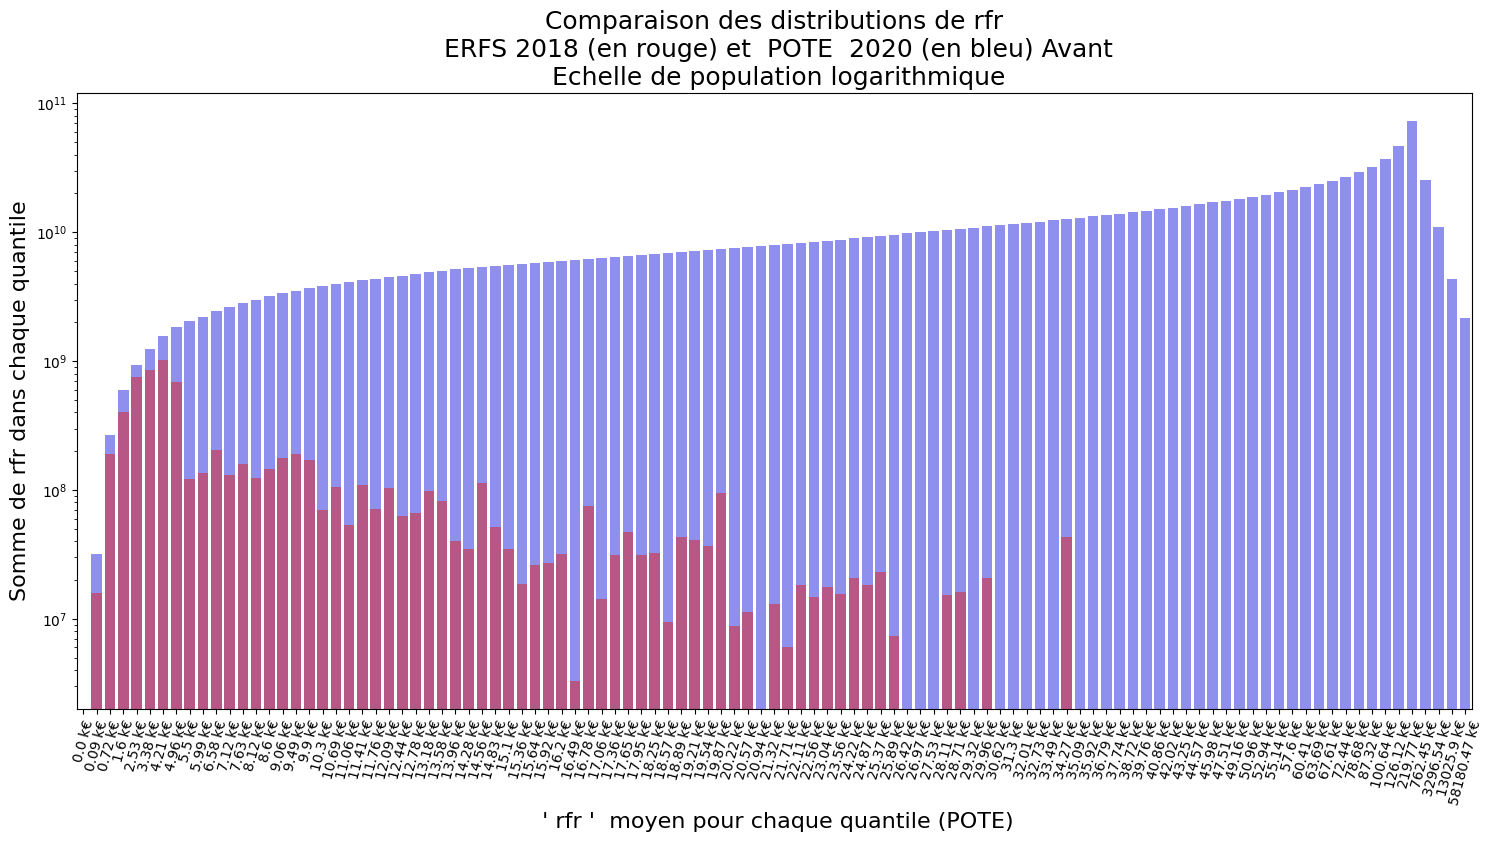

In [ ]:
fig, error_df, final_error = compare_distributions(
    Distrib_BASE.df, Distrib_POTE.df, variable, annee_erfs, annee_pote, "Avant", log
)

#### Création d'une base de test (où il manque des gens)

In [ ]:
base_ind.sort_values(by=variable, inplace=True)
base_ind[variable]
base_ind = base_ind[base_ind[variable] < 5000]

# leximpact_scenario.delete_arrays()

88073       0.0
66781       0.0
66782       0.0
66783       0.0
66784       0.0
          ...  
83863    4995.0
59084    4995.0
83860    4995.0
83862    4995.0
83861    4995.0
Name: rfr, Length: 16767, dtype: float32

In [ ]:
Distrib_BASE2, Distrib_POTE2, quantiles = distrib_to_quantiles(
    individus_to_entity(base_ind, "foyer_fiscal"), variable, quantiles
)

On a une base initiale de  16767  individus pour  9562 foyer_fiscal s
On regroupe la base selon  ['weight_individus', 'weight_familles', 'weight_foyers', 'foyer_fiscal_id']
On a  9562 foyer_fiscal apres le groupby
Nombre de foyers de  rfr à zéro, dans l'ERFS :  3572896.0 et dans POTE :  2789455 soit un écart de :  28.08580887664436 %
[0, 0.5, 326.0, 1145.0, 2058.0, 3000.0, 3801.0, 4591.0, 5307.0, 5691.0, 6294.0, 6865.0, 7383.0, 7879.0, 8364.0, 8829.0, 9278.0, 9703.0, 10103.0, 10496.0, 10881.0, 11230.0, 11589.0, 11919.0, 12263.0, 12609.0, 12959.0, 13388.0, 13774.0, 14140.0, 14422.0, 14700.0, 14967.0, 15234.0, 15499.0, 15781.0, 16062.0, 16347.0, 16634.0, 16920.0, 17209.0, 17504.0, 17804.0, 18103.0, 18409.0, 18726.0, 19048.0, 19374.0, 19701.0, 20041.0, 20393.0, 20757.0, 21132.0, 21514.0, 21909.0, 22323.0, 22794.0, 23280.0, 23874.0, 24580.0, 25122.0, 25628.0, 26155.0, 26696.0, 27250.0, 27819.0, 28406.0, 29012.0, 29635.0, 30283.0, 30954.0, 31648.0, 32366.0, 33105.0, 33872.0, 34669.0, 35505.

/home/jupyter-sasha/leximpact-prepare-data/leximpact_prepare_data/helpers_survey_scenario.py:158: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sample_entity = sample_individus.groupby(wprm_list, as_index=False).sum()


Erreur moyenne des buckets de  rfr  :  94.25614025514825  %
Erreur min :  19.966570932336598 erreur max:  100.0


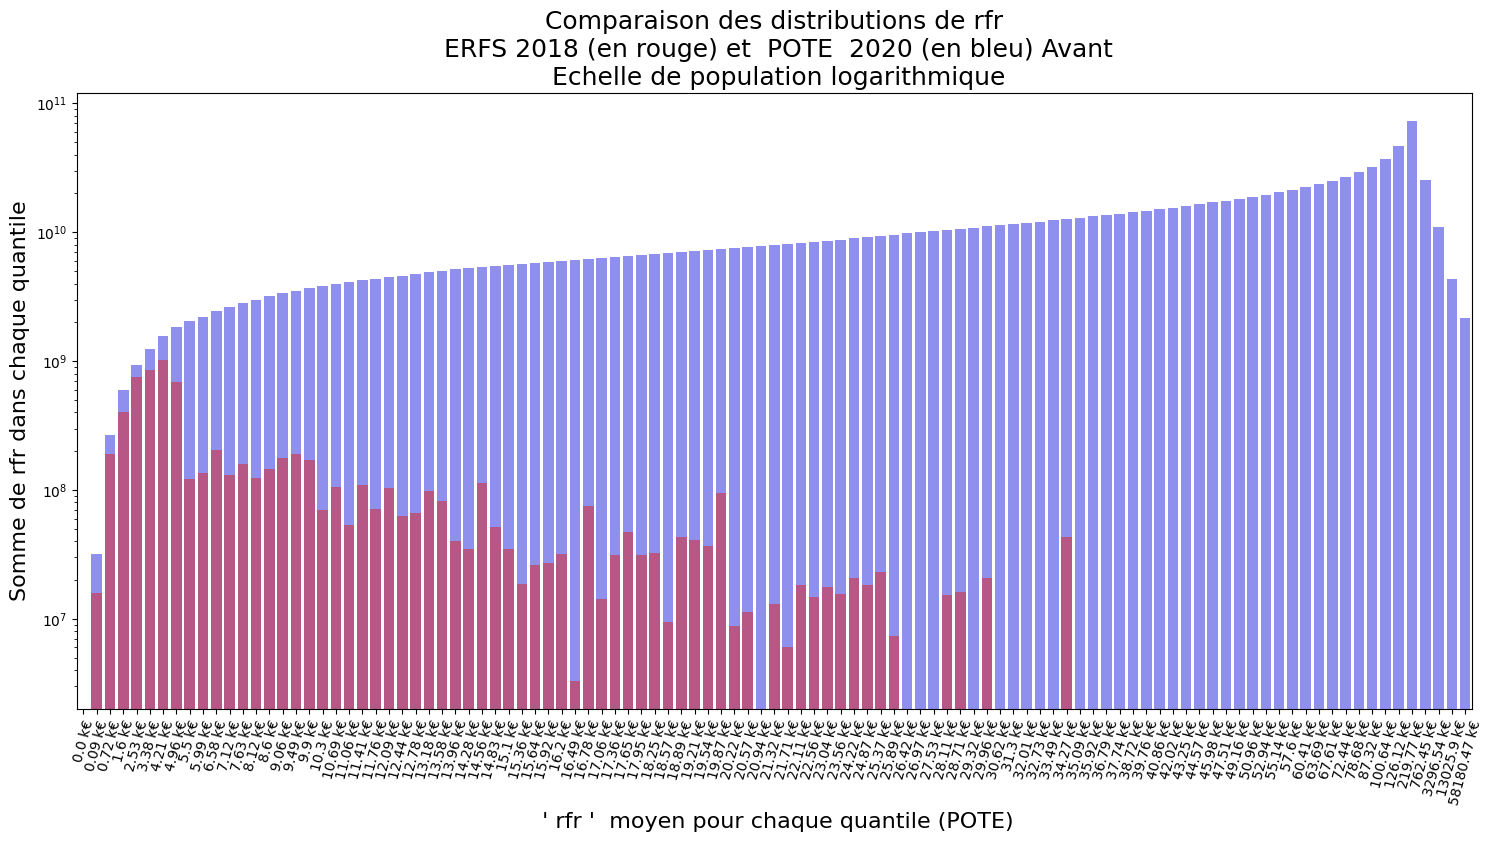

In [ ]:
fig, error_df, final_error = compare_distributions(
    Distrib_BASE2.df, Distrib_POTE.df, variable, annee_erfs, annee_pote, "Avant", log
)

#### Ajout de gens dans la base de test

In [ ]:
Distrib_BASE3, Distrib_POTE3 = add_missing_indiv(
    leximpact_scenario, annee_pote, variable
)

In [ ]:
fig, error_df, final_error = pote_comparison(
    Distrib_BASE.df, variable, title_suffix="", log=True, base_ff_cal=Distrib_BASE3.df
)

------------------------
Essais et tâtonnements

## TESTS

In [ ]:
def test_distrib_to_quantiles():
    variable = "retraite_brute"
    scenario = LeximpactErfsSurveyScenario(final_year=2022)
    quantiles = get_quantiles_casd(variable)

    # On va chercher notre base
    ids = [
        "menage_ordinaire",
        "menage_ordinaire_familles",
        "menage_ordinaire_foyers_fiscaux",
        "menage_ordinaire_individus",
        "weight_familles",
        "weight_foyers",
        "weight_individus",
        "weight_menages",
        "wprm",
        "wprm_init",
    ]
    var_list = scenario.used_as_input_variables + ids
    base_indiv = scenario.create_data_frame_by_entity(
        variables=var_list, period=2019, merge=True
    )

    Distrib_BASE, Distrib_POTE, quantiles = distrib_to_quantiles(
        base_indiv, variable, quantiles
    )

    assert Distrib_BASE.df.equals(Distrib_POTE.df) == 0

    print("en cours")


test_distrib_to_quantiles()

In [ ]:
def test_add_missing_indiv_retraite():
    variable = "retraite_imposable"
    leximpact_scenario = LeximpactErfsSurveyScenario(final_year=2022)
    add_missing_indiv(leximpact_scenario, 2019, variable)


test_add_missing_indiv_retraite()